In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image

In [11]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
import gc
gc.collect()
# data = pd.read_csv(r'/content/gdrive/My Drive/plant-pathology-2020-fgvc7/train.csv')

56

In [13]:
data = os.listdir(r"/content/gdrive/My Drive/Digits" )
data_X = []
data_y = []
data_classes = len(data)
for i in range (0,data_classes):
    data_list = os.listdir(r"/content/gdrive/My Drive/Digits" +"/"+str(i))
    for j in data_list:
        pic = cv2.imread(r"/content/gdrive/My Drive/Digits" +"/"+str(i)+"/"+j)
        pic = cv2.resize(pic,(32,32))
        data_X.append(pic)
        data_y.append(i)


if len(data_X) == len(data_y) :
    print("Total Dataponits = ",len(data_X))

# Labels and images
data_X = np.array(data_X)
data_y = np.array(data_y)

Total Dataponits =  10160


In [14]:
train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


In [15]:
# Preprocessing the images for neuralnet

def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

#Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

In [16]:
train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

In [17]:
model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                    

In [22]:
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon = 1e-08, decay=0.0)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

#Fit the model

history = model.fit(datagen.flow(train_X, train_y, batch_size=32),
                              epochs = 30, validation_data = (valid_X, valid_y),
                              verbose = 2, steps_per_epoch= 200)

Epoch 1/30
200/200 - 189s - loss: 1.1312 - accuracy: 0.6001 - val_loss: 0.1490 - val_accuracy: 0.9539 - 189s/epoch - 945ms/step
Epoch 2/30
200/200 - 208s - loss: 0.2974 - accuracy: 0.9021 - val_loss: 0.0537 - val_accuracy: 0.9814 - 208s/epoch - 1s/step
Epoch 3/30
200/200 - 191s - loss: 0.2093 - accuracy: 0.9326 - val_loss: 0.0398 - val_accuracy: 0.9891 - 191s/epoch - 957ms/step
Epoch 4/30
200/200 - 175s - loss: 0.1571 - accuracy: 0.9500 - val_loss: 0.0302 - val_accuracy: 0.9907 - 175s/epoch - 874ms/step
Epoch 5/30
200/200 - 183s - loss: 0.1359 - accuracy: 0.9589 - val_loss: 0.0447 - val_accuracy: 0.9876 - 183s/epoch - 916ms/step
Epoch 6/30
200/200 - 186s - loss: 0.1204 - accuracy: 0.9622 - val_loss: 0.0309 - val_accuracy: 0.9907 - 186s/epoch - 928ms/step
Epoch 7/30
200/200 - 187s - loss: 0.0991 - accuracy: 0.9690 - val_loss: 0.0273 - val_accuracy: 0.9912 - 187s/epoch - 935ms/step
Epoch 8/30
200/200 - 173s - loss: 0.0833 - accuracy: 0.9733 - val_loss: 0.0291 - val_accuracy: 0.9933 - 173

In [23]:
model.save('my_model_cv.h5')
model.save('/content/gdrive/My Drive/my_model_cv1.h5')
score = model.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.0339982733130455
Test Accuracy = 0.9881889820098877


_297_8825327.jpeg


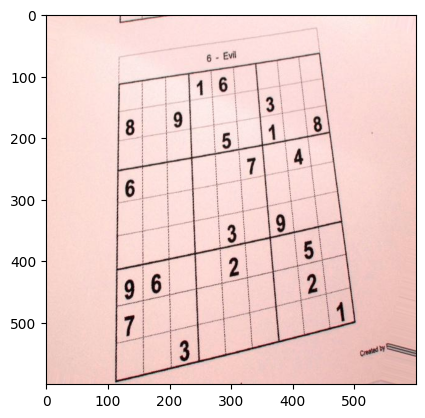

In [26]:
folder=r"/content/gdrive/My Drive/Digits/aug"

a=random.choice(os.listdir(folder))
print(a)
sudoku_a = cv2.imread(folder+'/'+a)
plt.figure()
plt.imshow(sudoku_a)
plt.show()

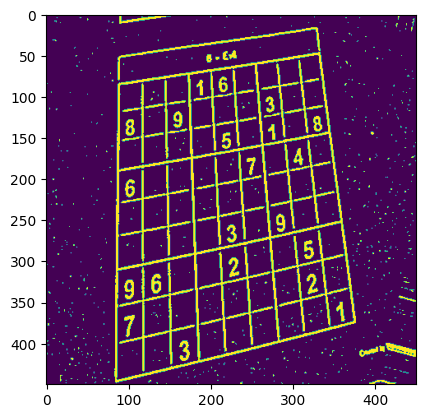

In [27]:
sudoku_a = cv2.resize(sudoku_a, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3),6)
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.show()

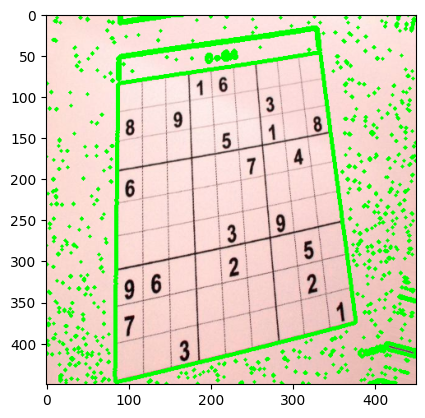

In [28]:
# Finding the outline of the sudoku puzzle in the image
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

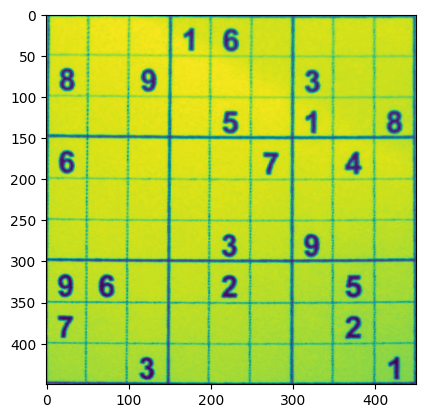

In [29]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(imagewrap)
plt.show()

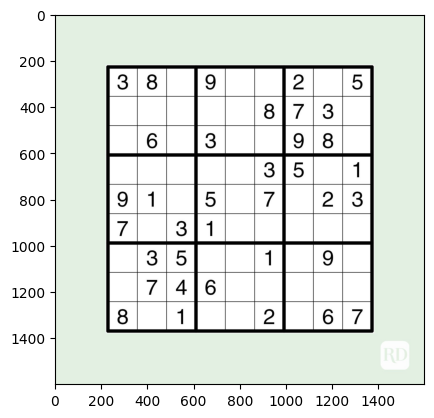

In [30]:
puzzle = cv2.imread("/content/gdrive/My Drive/Digits/su.jpg")

#let's see what we got
plt.figure()
plt.imshow(puzzle)
plt.show()

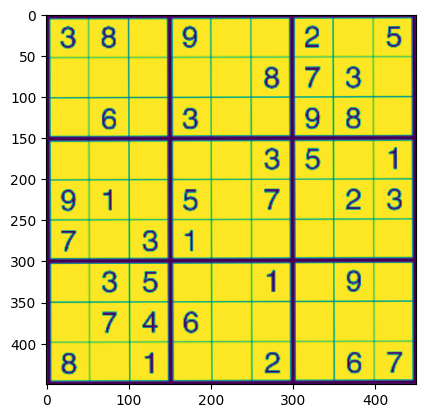

In [31]:
# Resizing puzzle to be solved
puzzle = cv2.resize(puzzle, (450,450))
# Preprocessing Puzzle
su_puzzle = preprocess(puzzle)

# Finding the outline of the sudoku puzzle in the image
su_contour_1= su_puzzle.copy()
su_contour_2= sudoku_a.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour,-1,(0,255,0),3)

black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(su_imagewrap)
plt.show()

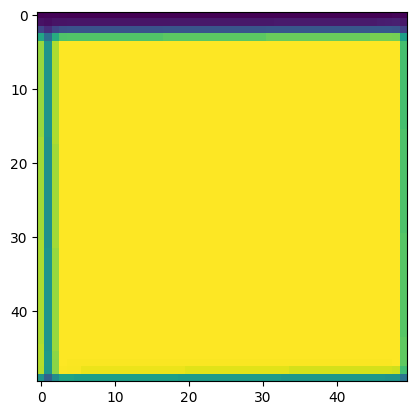

In [32]:
sudoku_cell = splitcells(su_imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[58])
plt.show()

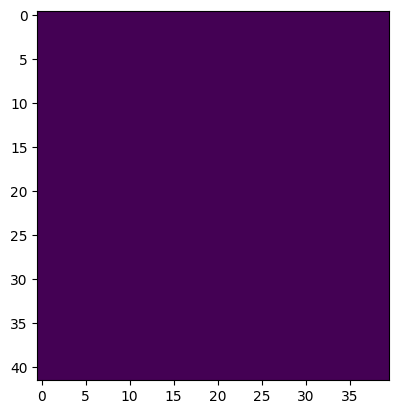

In [33]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:

        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)

    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[58])
plt.show()

In [37]:
def read_cells(cell,model):

    result = []
    for image in cell:
        # preprocess the image as it was in the model
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        # getting predictions and setting the values if probabilities are above 65%

        predictions = model.predict(img)
        #classIndex = model.predict_classes(img)
        predictions1 = np.argmax(model.predict(img),axis=1)
        print(predictions1)
        probabilityValue = np.amax(predictions)

        if probabilityValue > 0.65:
            result.append(predictions1)
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

1/1 [==============================] - 0s 36ms/step
[3]
1/1 [==============================] - 0s 29ms/step
[8]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 28ms/step
[9]
1/1 [==============================] - 0s 37ms/step
[1]
1/1 [==============================] - 0s 65ms/step
[1]
1/1 [==============================] - 0s 44ms/step
[2]
1/1 [==============================] - 0s 53ms/step
[1]
1/1 [==============================] - 0s 71ms/step
[5]
1/1 [==============================] - 0s 46ms/step
[1]
1/1 [==============================] - 0s 49ms/step
[1]
1/1 [==============================] - 0s 48ms/step
[1]
1/1 [==============================] - 0s 63ms/step
[1]
1/1 [==============================] - 0s 55ms/step
[1]
1/1 [==============================] - 0s 46ms/step
[8]
1/1 [==============================] - 0s 48ms/step
[7]
1/1 [==============================] - 0s 47ms/step
[3]
1/1 [==============================] - 0s 46ms/s

<ipython-input-37-1068bd7487f1>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid = np.asarray(grid)


In [38]:
grid = np.reshape(grid,(9,9))
grid

array([[array([3]), array([8]), 0, array([9]), 0, 0, array([2]), 0,
        array([5])],
       [0, 0, 0, 0, 0, array([8]), array([7]), array([3]), 0],
       [0, array([6]), 0, array([3]), 0, 0, array([9]), array([8]), 0],
       [0, 0, 0, 0, 0, array([3]), array([5]), 0, array([1])],
       [array([9]), array([1]), 0, array([5]), 0, array([7]), 0,
        array([2]), array([3])],
       [array([7]), 0, array([3]), array([1]), 0, 0, 0, 0, 0],
       [0, array([3]), array([5]), 0, 0, array([1]), 0, array([9]), 0],
       [0, array([7]), array([4]), array([6]), 0, 0, 0, 0, 0],
       [array([8]), 0, array([1]), 0, 0, array([2]), 0, array([6]),
        array([7])]], dtype=object)

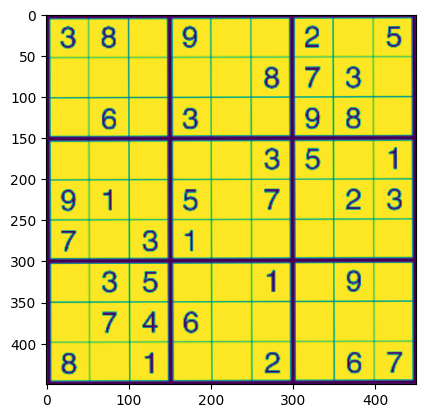

In [39]:
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

In [40]:
def next_box(quiz):
    for row in range(9):
        for col in range(9):
            if quiz[row][col] == 0:
                return (row, col)
    return False

#Function to fill in the possible values by evaluating rows collumns and smaller cells

def possible (quiz,row, col, n):
    #global quiz
    for i in range (0,9):
        if quiz[row][i] == n and row != i:
            return False
    for i in range (0,9):
        if quiz[i][col] == n and col != i:
            return False

    row0 = (row)//3
    col0 = (col)//3
    for i in range(row0*3, row0*3 + 3):
        for j in range(col0*3, col0*3 + 3):
            if quiz[i][j]==n and (i,j) != (row, col):
                return False
    return True

#Recursion function to loop over untill a valid answer is found.

def solve(quiz):
    val = next_box(quiz)
    if val is False:
        return True
    else:
        row, col = val
        for n in range(1,10): #n is the possible solution
            if possible(quiz,row, col, n):
                quiz[row][col]=n
                if solve(quiz):
                    return True
                else:
                    quiz[row][col]=0
        return

def Solved(quiz):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print("....................")

        for col in range(9):
            if col % 3 == 0 and col != 0:
                print("|", end=" ")

            if col == 8:
                print(quiz[row][col])
            else:
                print(str(quiz[row][col]) + " ", end="")

In [41]:
solve(grid)

True

In [42]:
if solve(grid):
    Solved(grid)
else:
    print("Solution don't exist. Model misread digits.")

[3] [8] 7 | [9] 4 6 | [2] 1 [5]
5 4 9 | 2 1 [8] | [7] [3] 6
1 [6] 2 | [3] 7 5 | [9] [8] 4
....................
4 2 6 | 8 9 [3] | [5] 7 [1]
[9] [1] 8 | [5] 6 [7] | 6 [2] [3]
[7] 5 [3] | [1] 2 4 | 8 4 9
....................
6 [3] [5] | 7 8 [1] | 4 [9] 2
2 [7] [4] | [6] 3 9 | 1 5 8
[8] 9 [1] | 4 5 [2] | 3 [6] [7]
